In [1]:
# Local imports
import time

# External imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
import spektral as sp
import scipy as sc

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
# Load graph-MNIST dataset
mnist = sp.datasets.mnist.MNIST(p_flip=0.0, k=8)

In [4]:
# Prepare Ahat
A = mnist.a.todense()
A_tilde = A + np.eye(N=A.shape[0])
D_tilde = np.diagflat(A_tilde.sum(axis=1))
D_rt = sc.linalg.fractional_matrix_power(D_tilde, -1/2)
Ahat = D_rt @ A_tilde @ D_rt
Ahat = np.array(Ahat, dtype='float32')

In [5]:
# Prepare dataset
train_size = 4000
val_size = 2000
test_size = 1000
batch_size = 32

# Define training, validation and test_data
x_train = np.array([mnist[i].x for i in range(0, train_size)], dtype='float32')
y_train = np.array([mnist[i].y for i in range(0, train_size)], dtype='float32')

x_val = np.array([mnist[i].x for i in range(train_size, train_size+val_size)], dtype='float32')
y_val = np.array([mnist[i].y for i in range(train_size, train_size+val_size)], dtype='float32')

x_test = np.array([mnist[i].x for i in range(train_size+val_size, train_size+val_size+test_size)], dtype='float32')
y_test = np.array([mnist[i].y for i in range(train_size+val_size, train_size+val_size+test_size)], dtype='float32')

# (x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train, x_test = x_train / 255.0, x_test / 255.0

# # Add a channels dimension
# x_train = x_train[..., tf.newaxis].astype("float32")
# x_test = x_test[..., tf.newaxis].astype("float32")

# Add data formatting and preparation here
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)

val_ds = test_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

In [19]:
class GCNLayer(tf.keras.layers.Layer):
    def __init__(self, conv_size, Ahat, act=tf.nn.relu):
        super(GCNLayer, self).__init__()
        self.Ahat = Ahat
        self.F = conv_size # Output is NxF - decide N at build time
        self.act = tf.nn.relu
    
    def build(self, input_shape):
        self.N = input_shape[0]
        self.C = input_shape[2]
        # Define the weight matrix for this layer - of size CxF
        self.kernel = self.add_weight('kernel', 
                                     shape=[self.C, self.F],
                                     dtype='float32')
        
    def call(self, X):
        # Perform forward pass, calculates Z
        b = tf.matmul(self.Ahat, tf.matmul(X, self.kernel))
        Z = self.act(b)
        return Z
    
class GCNModel(Model):
    def __init__(self, Ahat):
        super(GCNModel, self).__init__()
        self.Ahat = Ahat
        self.gcn1 = GCNLayer(32, self.Ahat, act=tf.nn.relu)
        self.gcn2 = GCNLayer(64, self.Ahat, act=tf.nn.relu)
        self.add = tf.keras.layers.Add()
        self.d1 = tf.keras.layers.Dense(512, activation='relu')
        self.d2 = tf.keras.layers.Dense(28)

    def call(self, X):
        N = X.shape[1]
        # 1. GCN layers
        O1 = self.gcn1(X)
        O2 = self.gcn2(O1)
        # 2. Aggegate nodal values by summing over nodes => NxF -> global vector of length F
        # Note that this is invariant under permutation of the graph!
        split_O = tf.split(O2, num_or_size_splits=N, axis=1)
        x = tf.keras.layers.Add()(split_O)
#         x = tf.math.reduce_sum(O2, axis=1)
        # 3. Apply FCNN for classification
        x = self.d1(x)
        return self.d2(x)

# Create an instance of the model and define loss etc.
# Update these with real data!
model = GCNModel(Ahat)

In [20]:
# Loss & metrics
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [21]:
# Training using GradientTape
@tf.function
def train_step(graphs, labels):
    with tf.GradientTape() as tape:
        predictions = model(graphs)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, predictions)

@tf.function
def test_step(graphs, labels):
    predictions = model(graphs)
    t_loss = loss_object(labels, predictions)
    
    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [22]:
EPOCHS = 5

start = time.time()

tr_loss = []
tr_acc = []

te_loss = []
te_acc = []

for epoch in range(EPOCHS):
    epoch_start = time.time()
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    for graphs, labels in train_ds:
        train_step(graphs, labels)
    
    for test_graphs, test_labels in test_ds:
        test_step(test_graphs, test_labels)
        
        
    tr_loss.append(train_loss.result())
    tr_acc.append(train_accuracy.result())
    te_loss.append(test_loss.result())
    te_acc.append(test_accuracy.result())
    
    epoch_end = time.time()
    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result():.3f}, '
        f'Accuracy: {train_accuracy.result():.3f}, '
        f'Test Loss: {test_loss.result():.3f}, '
        f'Test Accuracy: {test_accuracy.result():.3f}, '
        f'Epoch time: {(epoch_end - epoch_start):.2f} s'
    )
    print('\n')
    
end = time.time()
print(f'Total time: {(end - start):.2f} s')

Epoch 1, Loss: 2.506, Accuracy: 0.097, Test Loss: 2.342, Test Accuracy: 0.100, Epoch time: 13.69 s


Epoch 2, Loss: 2.345, Accuracy: 0.103, Test Loss: 2.411, Test Accuracy: 0.100, Epoch time: 11.06 s


Epoch 3, Loss: 2.298, Accuracy: 0.096, Test Loss: 2.291, Test Accuracy: 0.100, Epoch time: 11.06 s


Epoch 4, Loss: 2.242, Accuracy: 0.104, Test Loss: 2.249, Test Accuracy: 0.098, Epoch time: 11.04 s


Epoch 5, Loss: 2.208, Accuracy: 0.104, Test Loss: 2.193, Test Accuracy: 0.107, Epoch time: 11.42 s


Total time: 58.27 s


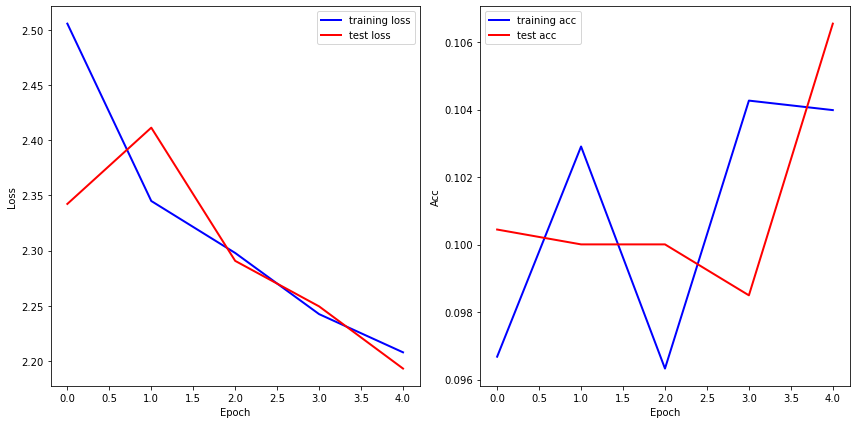

In [23]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].plot(tr_loss, linewidth=2, c = 'b', label='training loss')
ax[0].plot(te_loss, linewidth=2, c = 'r', label='test loss')

ax[1].plot(tr_acc, linewidth=2, c = 'b', label='training acc')
ax[1].plot(te_acc, linewidth=2, c = 'r', label='test acc')

ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Acc')
ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')

ax[0].legend(loc='best')
ax[1].legend(loc='best')

plt.tight_layout()
